## Getting data

In [ ]:
import polars as pl
import polars.selectors as cs
import glob
import pandas as pd


our_f = "./position_based.csv"
dss_f = "./new.dss.CpG.hg38DML.csv"
methylkit_f = "./new.methylkit..destranded.CpG.hg38.non.window.cov.10.csv"
methylsig_f = "./new.methylSig..hg38.non.window.csv"


# DSS does not add sample level information to the final results, so we need the original files
input_files = "./final_R*_bc_5mc_5hmc_sup/analysis/filtered_bam/???/filtered/filtered_CpG/new_destranded_filtered_Methy5mC_*.bam_5mc.methyl1_filtered_1.CpG.bed"




case_str = "Case"
ctr_str = "Control"


In [229]:
our = pd.read_csv(our_f)
dss = pd.read_csv(dss_f)
methylkit = pd.read_csv(methylkit_f)
methylSig = pd.read_csv(methylsig_f)

## Getting positions and methylations from the original files

In [230]:

inputs = glob.glob(input_files)
data = {"all": []}

for k, v in enumerate(inputs):
	print( k, v)
	data["all"].append(pl.read_csv(v, separator="\t", has_header=False, columns=[0,1,2,5,9,10], new_columns=["chrom", "chromStart", "chromEnd", "strand", "coverage_"+str(k), "blockSizes_"+str(k)], infer_schema_length=100000, dtypes={"coverage_"+str(k): pl.datatypes.Float32, "blockSizes_"+str(k): pl.datatypes.Float32}))

all = data["all"][0]
del(data["all"][0])



for e in range(0, len(data["all"])):
	print(e)
	all = all.join(data["all"][e], on=["chrom", "chromStart", "chromEnd", "strand"], how='full', coalesce=True)
	

all_p = all.to_pandas()

0 /mnt/labshare/share/project_data/Prasun/ONT_data/DNA_seq/final_R10_bc_5mc_5hmc_sup/analysis/filtered_bam/WTA/filtered/filtered_CpG/new_destranded_filtered_Methy5mC_WTA.bam_5mc.methyl1_filtered_1.CpG.bed


/tmp/ipykernel_3542666/1273766253.py:6: DeprecationWarning: The argument `dtypes` for `read_csv` is deprecated. It has been renamed to `schema_overrides`.
  data["all"].append(pl.read_csv(v, separator="\t", has_header=False, columns=[0,1,2,5,9,10], new_columns=["chrom", "chromStart", "chromEnd", "strand", "coverage_"+str(k), "blockSizes_"+str(k)], infer_schema_length=100000, dtypes={"coverage_"+str(k): pl.datatypes.Float32, "blockSizes_"+str(k): pl.datatypes.Float32}))


1 /mnt/labshare/share/project_data/Prasun/ONT_data/DNA_seq/final_R10_bc_5mc_5hmc_sup/analysis/filtered_bam/KOB/filtered/filtered_CpG/new_destranded_filtered_Methy5mC_KOB.bam_5mc.methyl1_filtered_1.CpG.bed
2 /mnt/labshare/share/project_data/Prasun/ONT_data/DNA_seq/final_R9_bc_5mc_5hmc_sup/analysis/filtered_bam/WTA/filtered/filtered_CpG/new_destranded_filtered_Methy5mC_WTA.bam_5mc.methyl1_filtered_1.CpG.bed
3 /mnt/labshare/share/project_data/Prasun/ONT_data/DNA_seq/final_R9_bc_5mc_5hmc_sup/analysis/filtered_bam/KOB/filtered/filtered_CpG/new_destranded_filtered_Methy5mC_KOB.bam_5mc.methyl1_filtered_1.CpG.bed
0
1
2


## adding positions to the data

In [231]:
dss_f = dss.merge(all_p, how='inner', left_on=["chr", "pos"], right_on=["chrom", "chromStart"])
methylkit_f = methylkit.merge(all_p, how='inner', left_on=["chr", "start"], right_on=["chrom", "chromStart"])
methylSig_f = methylSig.merge(all_p, how='inner', left_on=["seqnames", "start"], right_on=["chrom", "chromStart"])

## Get diff pos

In [233]:
dss_filtered = dss_f[(dss_f["fdr"] <= 0.05)]
our_filtered = our[(our["q-value"] <= 0.05)]
methylkit_filtered = methylkit_f[(methylkit_f["qvalue"] <= 0.05)]
methylSig_filtered = methylSig_f[(methylSig_f["fdr"] <= 0.05)]

## Get diff pos with 20 diff

In [236]:
dss_filtered_20 = dss_f[(dss_f["fdr"] <= 0.05) & (dss_f["diff"].abs() >= 0.2)]
our_filtered_20 = our[(our["q-value"] <= 0.05) & (our["diff"].abs() >= 0.2)]
methylkit_filtered_20 = methylkit_f[(methylkit_f["qvalue"] <= 0.05) & (methylkit_f["meth.diff"].abs() >= 20)]
methylSig_filtered_20 = methylSig_f[(methylSig_f["fdr"] <= 0.05) & (methylSig_f["meth_diff"].abs() >= 20)]

# Intersections with our tool

In [240]:
our_dss = our_filtered.merge(dss_filtered, how='inner', left_on=["chrom", "chromStart"], right_on=["chr", "pos"])

our_methylkit = our_filtered.merge(methylkit_filtered, how='inner', left_on=["chrom", "chromStart"], right_on=["chr", "start"])

our_methylsig = our_filtered.merge(methylSig_filtered, how='inner', left_on=["chrom", "chromStart"], right_on=["seqnames", "start"])

all_sota = methylkit_filtered.merge(dss_filtered, how='inner', left_on=["chr", "start"], right_on=["chr", "pos"]).merge(methylSig_filtered, how='inner', left_on=["chr", "start"], right_on=["seqnames", "start"])



our_all = our_filtered.merge(all_sota, how='inner', left_on=["chrom", "chromStart"], right_on=['chr', 'start'], suffixes=('_df1', '_df2'))

## intersection 2 tools with 20p

In [242]:
dss_methylkit_20 = methylkit_filtered_20.merge(dss_filtered_20, how='inner', left_on=["chr", "start"], right_on=["chr", "pos"])

methylkit_methylsig_20 = methylSig_filtered_20.merge(methylkit_filtered_20, how='inner', left_on=["seqnames", "start"], right_on=["chr", "start"])

methylsig_dss_20 = methylSig_filtered_20.merge(dss_filtered_20, how='inner', left_on=["seqnames", "start"], right_on=["chr", "pos"])

methylsig_our_20 = methylSig_filtered_20.merge(our_filtered_20, how='inner', left_on=["seqnames", "start"], right_on=["chrom", "chromStart"])

dss_our_20 = dss_filtered_20.merge(our_filtered_20, how='inner', left_on=["chr", "pos"], right_on=["chrom", "chromStart"])

our_methylkit_20 = methylkit_filtered_20.merge(our_filtered_20, how='inner', left_on=["chr", "start"], right_on=["chrom", "chromStart"])

## Volcano plot for methylkit with overlapping pos with our tool

[6.05492926786011, 5.907833713810126, 7.7747792703570715, 6.765840045337142, 7.047660431874742, 6.148753138952117, 8.027900780251905, 5.660731040823253, 9.33346339840394, 6.642318775740677]
(10917571, 11)


/tmp/ipykernel_3542666/1170659489.py:65: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(significant["meth.diff"].to_numpy(), significant["neg_log10_fdr"].to_numpy(), s=3, cmap="Blues", c=significant["colors"])# ,


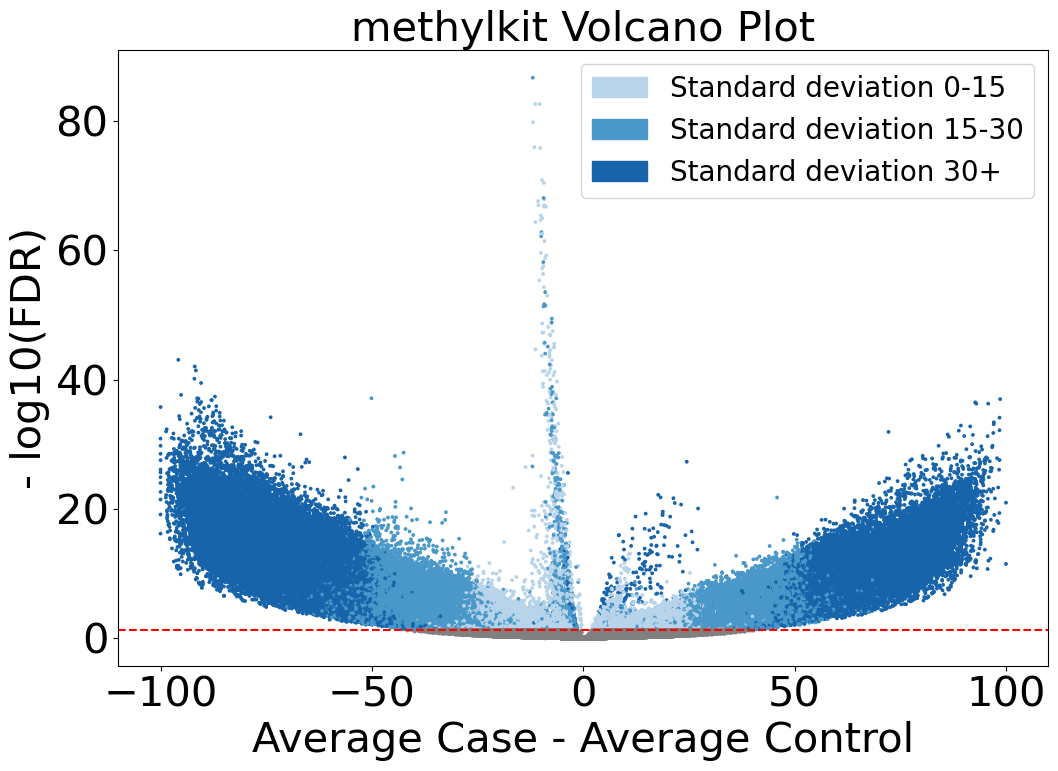

In [397]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import matplotlib.patches as mpatches

font = {'size'   : 18}
matplotlib.rc('font', **font)



our["stdv"] = (our.filter(like="blockSizes_") * 100).std(axis=1)


methylkit_stdv = our[["chrom", "chromStart", "stdv"]].merge(methylkit, how='inner', left_on=["chrom", "chromStart"], right_on=["chr", "start"])



ranges = {
    "Standard deviation 0-15": (0, 15, plt.cm.Blues(0.3)),   # Lightest Blue
    "Standard deviation 15-30": (15, 30, plt.cm.Blues(0.6)), # Dark Blue
    "Standard deviation 30+": (30, 100, plt.cm.Blues(0.8))   # Darkest Blue
}

colors = []

for val in methylkit_stdv["stdv"].to_list():
    for label, (low, high, color) in ranges.items():
        if low <= val <= high:
            colors.append(color)
            break


print(methylkit_stdv["stdv"].to_list()[:10])
print(methylkit_stdv.shape)



methylkit_stdv["colors"] = colors


fig, ax = plt.subplots(1,1, figsize=(12, 8))
fig.subplots_adjust(hspace=0.3)
methylkit["neg_log10_fdr"] = -1 * np.log10(methylkit["qvalue"])
methylkit["neg_log10_fdr"] = methylkit["neg_log10_fdr"]


methylkit_stdv["meth.diff"] = methylkit_stdv["meth.diff"]
significant = methylkit_stdv[methylkit_stdv["qvalue"] < 0.05]
ax.scatter(significant["meth.diff"].to_numpy(), significant["neg_log10_fdr"].to_numpy(), s=3, cmap="Blues", c=significant["colors"])# , 
insignificant = methylkit_stdv[methylkit_stdv["qvalue"] >= 0.05]
ax.scatter(insignificant["meth.diff"].to_numpy(), insignificant["neg_log10_fdr"].to_numpy(), s=3, c="gray")
ax.axhline(y = np.log10([0.05])[0] * -1, color = 'r', linestyle = '--', label=f'FDR = {0.05}')
ax.set_title("methylkit"+ ' Volcano Plot', fontsize=30)
ax.set_xlabel("Average " + case_str + " - Average " + ctr_str, fontsize=30)
ax.set_ylabel("- log10(FDR)", fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)


legend_patches = [mpatches.Patch(color=color, label=label) for label, (_, _, color) in ranges.items()]

ax.legend(handles=legend_patches, loc="best", fontsize=20)

plt.show()

## Count non null (change input files)

In [256]:
import polars as pl
import polars.selectors as cs
import glob
import pandas as pd


min_cov = 10


inputs = glob.glob(input_files)
data = {"all": []}

for k, v in enumerate(inputs):
    print( k, v)
    df = pl.read_csv(v, separator="\t", has_header=False, columns=[0,1,2,5,9,10], new_columns=["chrom", "chromStart", "chromEnd", "strand", "coverage_"+str(k), "blockSizes_"+str(k)], infer_schema_length=100000, dtypes={"coverage_"+str(k): pl.datatypes.Float32, "blockSizes_"+str(k): pl.datatypes.Float32})
    data["all"].append(df)

all = data["all"][0]

del(data["all"][0])



for e in range(0, len(data["all"])):
    print(e)
    all = all.join(data["all"][e], on=["chrom", "chromStart", "chromEnd", "strand"], how='full', coalesce=True)


all_p = all.to_pandas()


all_p = all_p.fillna(0)



available = (all_p.filter(like="coverage_") >= min_cov).sum(axis=1)

s = available.to_list()


all_p["non_null"] = s

all_p = all_p[["chrom", "chromStart", "chromEnd", "strand", "non_null"]]

0 /mnt/labshare/share/project_data/Prasun/ONT_data/DNA_seq/final_R10_bc_5mc_5hmc_sup/analysis/filtered_bam/WTA/filtered/filtered_CpG/new_destranded_filtered_Methy5mC_WTA.bam_5mc.methyl1_filtered_1.CpG.bed


/tmp/ipykernel_3542666/3183300266.py:15: DeprecationWarning: The argument `dtypes` for `read_csv` is deprecated. It has been renamed to `schema_overrides`.
  df = pl.read_csv(v, separator="\t", has_header=False, columns=[0,1,2,5,9,10], new_columns=["chrom", "chromStart", "chromEnd", "strand", "coverage_"+str(k), "blockSizes_"+str(k)], infer_schema_length=100000, dtypes={"coverage_"+str(k): pl.datatypes.Float32, "blockSizes_"+str(k): pl.datatypes.Float32})


1 /mnt/labshare/share/project_data/Prasun/ONT_data/DNA_seq/final_R10_bc_5mc_5hmc_sup/analysis/filtered_bam/KOB/filtered/filtered_CpG/new_destranded_filtered_Methy5mC_KOB.bam_5mc.methyl1_filtered_1.CpG.bed
2 /mnt/labshare/share/project_data/Prasun/ONT_data/DNA_seq/final_R9_bc_5mc_5hmc_sup/analysis/filtered_bam/WTA/filtered/filtered_CpG/new_destranded_filtered_Methy5mC_WTA.bam_5mc.methyl1_filtered_1.CpG.bed
3 /mnt/labshare/share/project_data/Prasun/ONT_data/DNA_seq/final_R9_bc_5mc_5hmc_sup/analysis/filtered_bam/KOB/filtered/filtered_CpG/new_destranded_filtered_Methy5mC_KOB.bam_5mc.methyl1_filtered_1.CpG.bed
0
1
2


## Volcano plot for DSS with overlapping pos with our tool

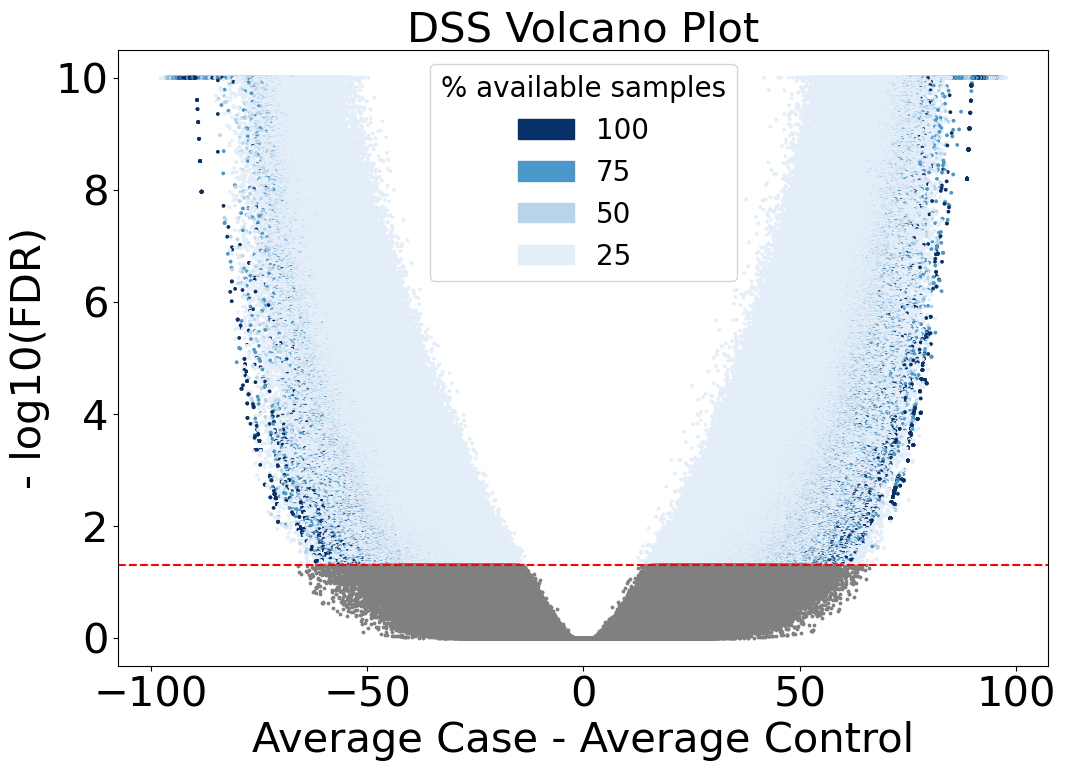

In [395]:
dss_c_null = dss.merge(all_p, how='inner', left_on=["chr", "pos"], right_on=["chrom", "chromStart"])



from matplotlib import pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import numpy as np




ranges = {
    "100": (0, 0, plt.cm.Blues(1.0)),   # Lightest Blue
    "75": (1, 1, plt.cm.Blues(0.6)),    # Medium-Light Blue
    "50": (2, 2, plt.cm.Blues(0.3)),   # Dark Blue
    "25": (3, 1000, plt.cm.Blues(0.1))    # Darkest Blue
}

colors = []
for val in dss_c_null["non_null"].to_list():
    for label, (low, high, color) in ranges.items():
        if low <= val <= high:
            colors.append(color)
            break
 
fig, ax = plt.subplots(1,1, figsize=(12, 8))
fig.subplots_adjust(hspace=0.3)
dss_c_null["neg_log10_fdr"] = -1 * np.log10(dss_c_null["fdr"])

dss_c_null["neg_log10_fdr"] = dss_c_null["neg_log10_fdr"].clip(upper=10)

dss_c_null["colors"] = colors


dss_our1 = dss_c_null.merge(our_filtered, how='inner', left_on=["chr", "pos"], right_on=["chrom", "chromStart"])


dss_our1["neg_log10_fdr"] = -1 * np.log10(dss_our1["fdr"])

significant = dss_c_null[dss_c_null["fdr"] < 0.05]
ax.scatter(significant["diff"] *100, significant["neg_log10_fdr"], s=3,  c=significant["colors"])
insignificant = dss_c_null[dss_c_null["fdr"] >= 0.05]
scatter = ax.scatter(insignificant["diff"] *100, insignificant["neg_log10_fdr"], s=3, c="gray")

ax.axhline(y = np.log10([0.05])[0] * -1, color = 'r', linestyle = '--', label=f'FDR = {0.05}')
ax.set_title("DSS"+ ' Volcano Plot', fontsize=30)
# ax.set_xlim(-1,1.2)
ax.set_xlabel("Average " + case_str + " - Average " + ctr_str, fontsize=30)
ax.set_ylabel("- log10(FDR)", fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)

legend_patches = [mpatches.Patch(color=color, label=label) for label, (_, _, color) in ranges.items()]

ax.legend(handles=legend_patches, title="% available samples", loc="best", fontsize=20, title_fontsize=20)

plt.show()


In [414]:
dss_c_null[dss_c_null["fdr"] <= 0.05]

,chr,pos,mu1,mu2,diff,diff.se,stat,phi1,phi2,pval,fdr,chrom,chromStart,chromEnd,strand,non_null,neg_log10_fdr,colors
0,chr20,19415201,0.995037,0.027034,0.968003,0.031859,30.384246,0.043870,0.029332,8.870864e-203,2.421126e-195,chr20,19415201,19415202,+,4,10.000000,"(0.8917339484813533, 0.9351018838908112, 0.975..."
1,chr5,44264611,0.027515,0.994406,-0.966890,0.032060,-30.158878,0.025561,0.049114,8.204641e-200,1.119647e-192,chr5,44264611,44264612,+,4,10.000000,"(0.8917339484813533, 0.9351018838908112, 0.975..."
2,chr13,48094049,0.038341,0.994685,-0.956344,0.032081,-29.810343,0.017730,0.049250,2.869261e-195,2.610360e-188,chr13,48094049,48094050,+,4,10.000000,"(0.8917339484813533, 0.9351018838908112, 0.975..."
3,chr2,16066943,0.995128,0.028421,0.966707,0.032552,29.697173,0.043918,0.027535,8.351877e-194,5.698698e-187,chr2,16066943,16066944,+,4,10.000000,"(0.8917339484813533, 0.9351018838908112, 0.975..."
4,chr5,137226800,0.995223,0.029269,0.965955,0.033047,29.229335,0.043967,0.027678,8.222277e-188,4.488214e-181,chr5,137226800,137226801,+,4,10.000000,"(0.8917339484813533, 0.9351018838908112, 0.975..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1760527,chr7,48339228,0.081571,0.401921,-0.320350,0.108762,-2.945415,0.052469,0.022742,3.225213e-03,4.999965e-02,chr7,48339228,48339229,+,4,1.301033,"(0.8917339484813533, 0.9351018838908112, 0.975..."
1760528,chr19,11468476,0.604642,0.256276,0.348366,0.118274,2.945415,0.037956,0.024125,3.225217e-03,4.999968e-02,chr19,11468476,11468477,+,4,1.301033,"(0.8917339484813533, 0.9351018838908112, 0.975..."
1760529,chr5,99645708,0.948401,0.682865,0.265537,0.090153,2.945414,0.047154,0.021223,3.225227e-03,4.999982e-02,chr5,99645708,99645709,+,4,1.301032,"(0.8917339484813533, 0.9351018838908112, 0.975..."
1760530,chr16,87665692,0.877341,0.603151,0.274190,0.093091,2.945413,0.016590,0.029392,3.225239e-03,4.999997e-02,chr16,87665692,87665693,+,4,1.301030,"(0.8917339484813533, 0.9351018838908112, 0.975..."


## Volcano plot of MethylSig

/tmp/ipykernel_3542666/4033600884.py:60: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(significant["meth_diff"].to_numpy(), significant["neg_log10_fdr"].to_numpy(), s=3, cmap="Blues")#, c=significant["colors"])# ,


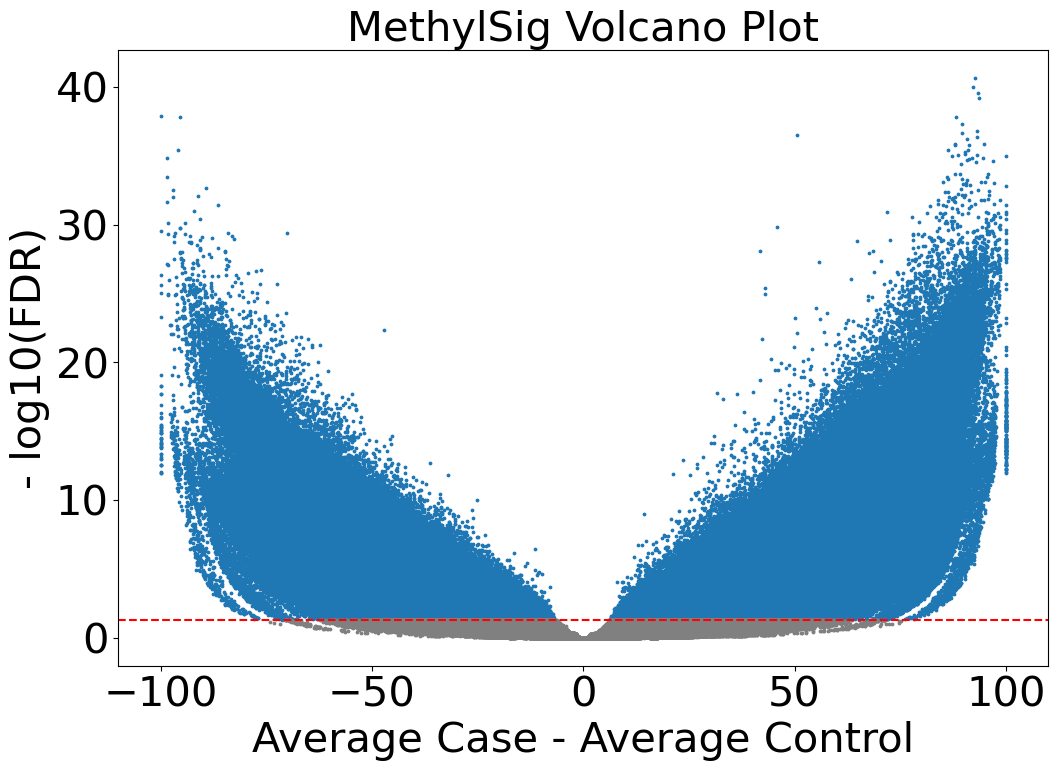

In [398]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import matplotlib.patches as mpatches


# methylkit_f

# our

font = {'size'   : 18}
matplotlib.rc('font', **font)



our["stdv"] = (our.filter(like="blockSizes_") * 100).std(axis=1)

methylSig_stdv = our[["chrom", "chromStart", "stdv"]].merge(methylSig, how='inner', left_on=["chrom", "chromStart"], right_on=["seqnames", "start"])



our_meth_overlap = our_filtered.merge(methylSig_stdv, how='inner', left_on=["chrom", "chromStart"], right_on=["seqnames", "start"])


fig, ax = plt.subplots(1,1, figsize=(12, 8))
fig.subplots_adjust(hspace=0.3)
methylSig_stdv["neg_log10_fdr"] = -1 * np.log10(methylSig_stdv["fdr"])
our_meth_overlap["neg_log10_fdr"] = -1 * np.log10(our_meth_overlap["fdr"])
methylSig_stdv["neg_log10_fdr"] = methylSig_stdv["neg_log10_fdr"]#.clip(upper=40)


our_meth_overlap["neg_log10_fdr"] = our_meth_overlap["neg_log10_fdr"]#.clip(upper=40)
methylSig_stdv["meth_diff"] = methylSig_stdv["meth_diff"]#.clip(upper=40, lower=-40)
our_meth_overlap["meth_diff"] = our_meth_overlap["meth_diff"]#.clip(upper=40, lower=-40)
significant = methylSig_stdv[methylSig_stdv["fdr"] < 0.05]
ax.scatter(significant["meth_diff"].to_numpy(), significant["neg_log10_fdr"].to_numpy(), s=3, cmap="Blues")#, c=significant["colors"])# , 
insignificant = methylSig_stdv[methylSig_stdv["fdr"] >= 0.05]
ax.scatter(insignificant["meth_diff"].to_numpy(), insignificant["neg_log10_fdr"].to_numpy(), s=3, c="gray")
ax.axhline(y = np.log10([0.05])[0] * -1, color = 'r', linestyle = '--', label=f'FDR = {0.05}')
ax.set_title("MethylSig"+ ' Volcano Plot', fontsize=30)
ax.set_xlabel("Average " + case_str + " - Average " + ctr_str, fontsize=30)
ax.set_ylabel("- log10(FDR)", fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)


legend_patches = [mpatches.Patch(color=color, label=label) for label, (_, _, color) in ranges.items()]

plt.show()

## Volcano plot of MethylDiffTools

/tmp/ipykernel_3542666/2322788267.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(significant["diff"].to_numpy() * 100, significant["neg_log10_fdr"].to_numpy(), s=5,cmap='viridis')
/tmp/ipykernel_3542666/2322788267.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/qgenlab/anaconda3/envs/limma/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


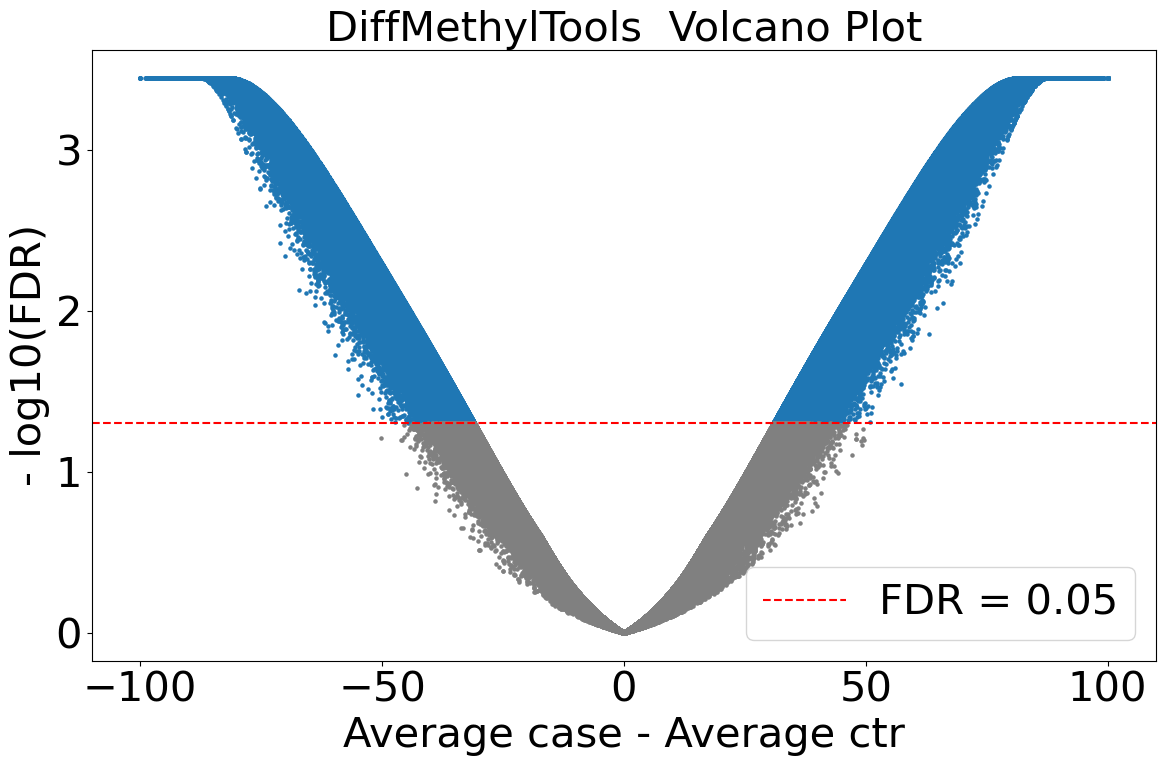

In [407]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import matplotlib.patches as mpatches


our_f = "/home/derbelh/analysis/DNA_data_pre/v.0.0.3.3/v0.0.3/new_Prasun2/data/position_based.csv"

our = pd.read_csv(our_f)


fig, ax = plt.subplots(1,1, figsize=(12, 8))
fig.subplots_adjust(hspace=0.3)
our["neg_log10_fdr"] = -1 * np.log10(our["q-value"])
significant = our[our["q-value"] < 0.05]
ax.scatter(significant["diff"].to_numpy() * 100, significant["neg_log10_fdr"].to_numpy(), s=5,cmap='viridis')
insignificant = our[our["q-value"] >= 0.05]
ax.scatter(insignificant["diff"].to_numpy() * 100, insignificant["neg_log10_fdr"].to_numpy(), s=5, c="gray")
ax.axhline(y = np.log10([0.05])[0] * -1, color = 'r', linestyle = '--', label=f'FDR = {0.05}')
ax.set_title("DiffMethylTools "+ ' Volcano Plot', fontsize=30)
ax.set_xlabel("Average case - Average ctr", fontsize=30)
ax.set_ylabel("- log10(FDR)", fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)
ax.legend(ax.get_legend_handles_labels()[0], ax.get_legend_handles_labels()[1], fontsize=30)

plt.tight_layout()


plt.show()

## Violin plots

### Missing intersections

### Stdv

In [416]:

dss_filtered_pos_only = dss_filtered.merge(our[["chrom", "chromStart"]], how='inner', left_on=["chr", "pos"], right_on=["chrom", "chromStart"]) # all_p = all_p[["chrom", "chromStart", "chromEnd", "strand", "non_null"]]



dss_only = dss_filtered_pos_only.merge(our_filtered, how='left', right_on=["chrom", "chromStart"], left_on=["chr", "pos"], indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

methyl_only = methylkit_filtered.merge(our_filtered, how='left', left_on=["chr", "start"], right_on=["chrom", "chromStart"], indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

methylsig_only = methylSig_filtered.merge(our_filtered, how='left', left_on=["seqnames", "start"], right_on=["chrom", "chromStart"], indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])



dss_filtered_pos_only.drop(['chrom_y', 'chromStart_y', 'chrom_x', 'chromStart_x'], axis=1, inplace=True)
methyl_only.drop(['chrom_x', 'chromStart_x', 'chromEnd_x', 'strand_y', 'chrom_y', 'chromStart_y', 'chromEnd_y'], axis=1, inplace=True)
methylsig_only.drop(['chrom_x', 'chromStart_x', 'chromEnd_x', 'strand_y', 'chrom_y', 'chromStart_y', 'chromEnd_y'], axis=1, inplace=True)



# print("dss_filtered_pos_only", dss_filtered_pos_only)
# print("methyl_only", methyl_only.columns)
# print("methylsig_only", methylsig_only.columns)
# print("our_filtered", our_filtered.columns)

our_only_1 = our_filtered.merge(dss_filtered_pos_only, how='left', right_on=["chr", "pos"], left_on=["chrom", "chromStart"], indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])# .rename(columns={'chrom_x': 'chrom', 'chromStart_x': 'chromStart'})

# print("our_only_1", our_only_1)

our_only_1 = our_only_1.loc[:, ~our_only_1.columns.duplicated()]


# print("our_only_1", our_only_1)
# print("methylkit_filtered", methylkit_filtered)
our_only_2 = our_only_1.merge(methylkit_filtered, how='left', right_on=["chr", "start"], left_on=["chrom", "chromStart"], indicator=True).query('_merge == "left_only"').drop(columns=['_merge']).dropna(axis=1)


# print(our_only_2)
# print(our_only_2.columns)

our_only = our_only_2.merge(methylSig_filtered, how='left', right_on=["seqnames", "start"], left_on=['chrom_x', 'chromStart_x'], indicator=True).query('_merge == "left_only"').drop(columns=['_merge']).dropna(axis=1)


# print(our_only)
# print(our_only.merge(methylSig_filtered, how='left', right_on=["seqnames", "start"], left_on=["Chr_x", "Pos_x"], indicator=True).query('_merge == "left_only"').drop(columns=['_merge']).dropna(axis=1))

In [292]:
dss_only_stdv = dss_only.filter(like="blockSizes_").std(axis=1).tolist()


methyl_only_stdv = methyl_only.filter(like="blockSizes_").std(axis=1).tolist()


methylsig_only_stdv = methylsig_only.filter(like="blockSizes_").std(axis=1).tolist()


our_only_stdv = our_only.filter(like="blockSizes_").applymap(lambda x: x * 100).std(axis=1).tolist() #####


our_dss_stdv = our_dss.filter(like="blockSizes_").std(axis=1).tolist()


our_methylkit_stdv = our_methylkit.filter(like="blockSizes_").std(axis=1).tolist()


our_methylsig_stdv = our_methylsig.filter(like="blockSizes_").std(axis=1).tolist()


all_sota_stdv = all_sota.filter(like="blockSizes_").std(axis=1).tolist()


our_all_stdv = our_all.filter(like="blockSizes_").std(axis=1).tolist()

/tmp/ipykernel_3542666/2618389000.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  our_only_stdv = our_only.filter(like="blockSizes_").applymap(lambda x: x * 100).std(axis=1).tolist() #####


### Plot

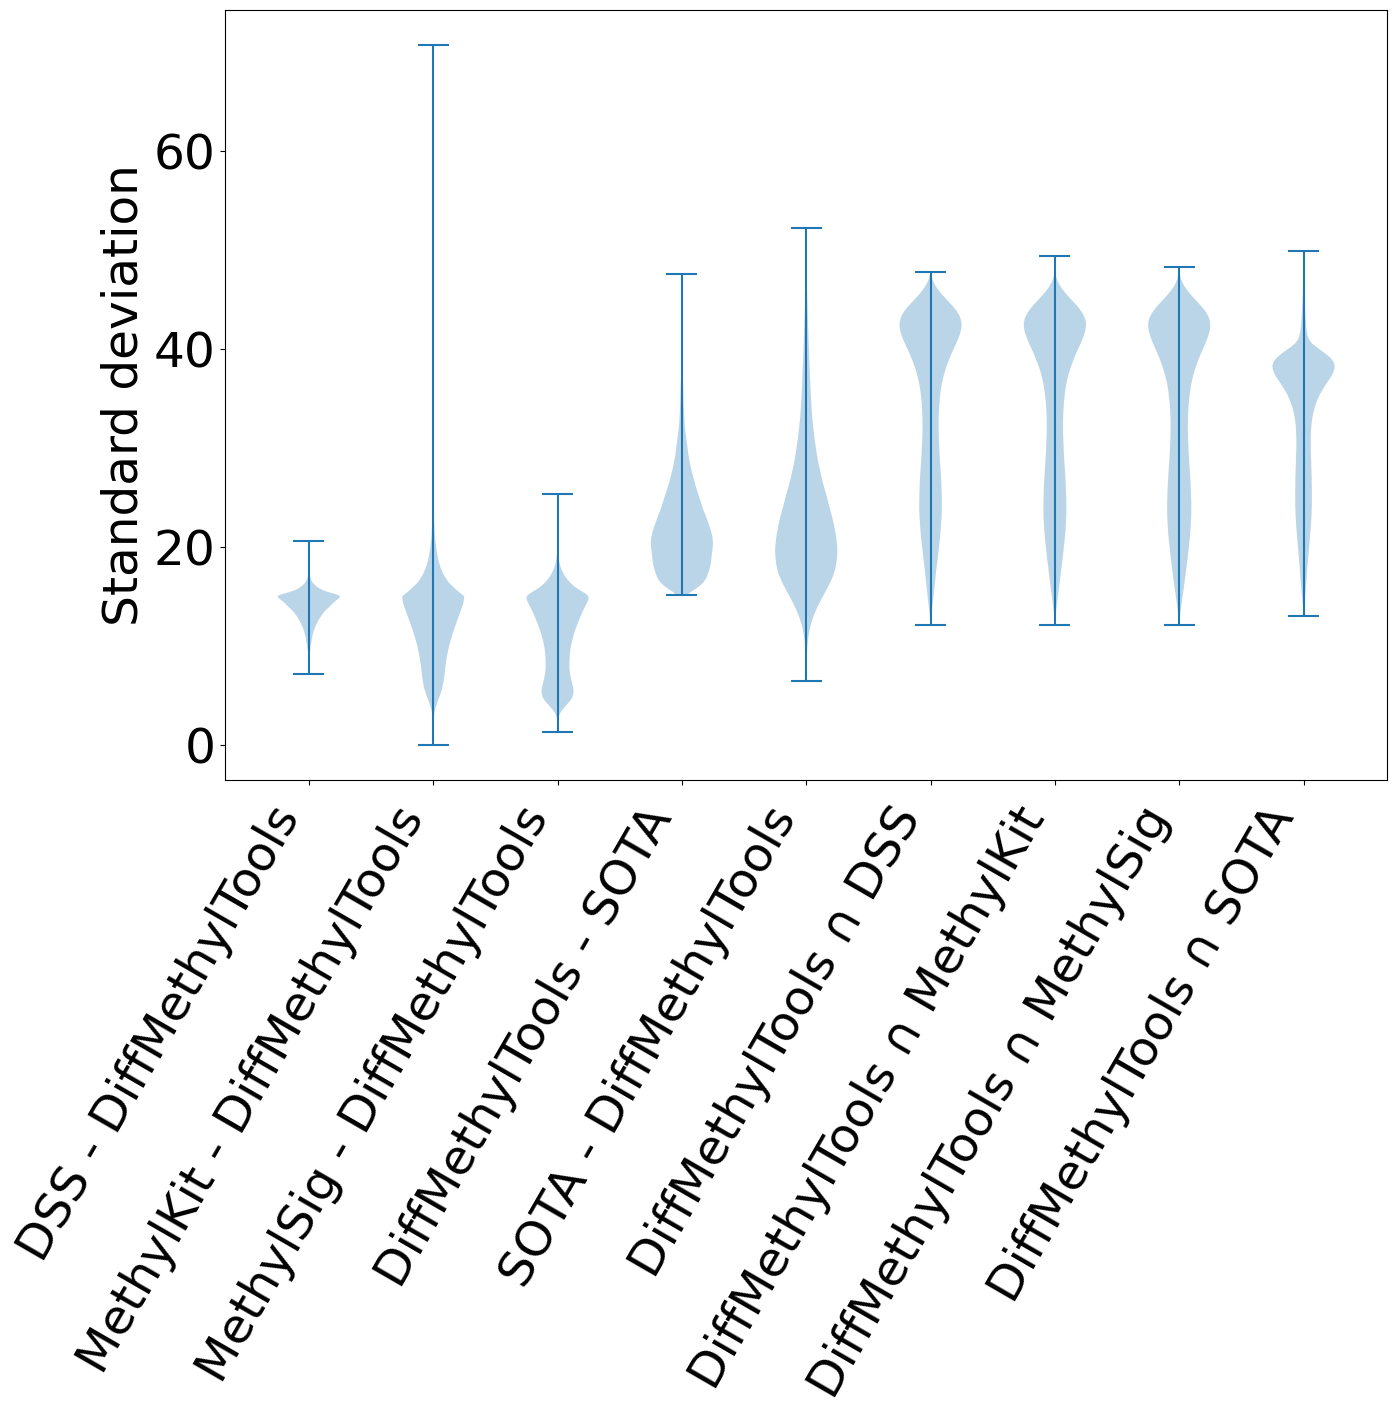

In [410]:
import math

# [x for x in methyl_only_stdv if not math.isnan(x)]
import matplotlib as mpl

mpl.rcParams['font.size'] = 35

data_with_labels = [
    (dss_only_stdv, "DSS - DiffMethylTools"),
    ([x for x in methyl_only_stdv if not math.isnan(x)], "MethylKit - DiffMethylTools"),
    (methylsig_only_stdv, "MethylSig - DiffMethylTools"),
    (our_only_stdv, "DiffMethylTools - SOTA"),
    (all_sota_stdv, "SOTA - DiffMethylTools"),
    (our_dss_stdv, "DiffMethylTools ∩ DSS"),
    (our_methylkit_stdv, "DiffMethylTools ∩ MethylKit"),
    (our_methylsig_stdv, "DiffMethylTools ∩ MethylSig"),
    (our_all_stdv, "DiffMethylTools ∩ SOTA")
]
#  ∩
filtered_data_with_labels = [(data, label) for data, label in data_with_labels if len(data) > 0]

filtered_data, labels = zip(*filtered_data_with_labels) if filtered_data_with_labels else ([], [])

plt.figure(figsize=(15, 10))
if filtered_data:
    plt.violinplot(filtered_data)
    plt.xticks(range(1, len(labels) + 1), labels)
    plt.ylabel("Standard deviation")
    plt.xticks(rotation=60, ha="right")
    plt.tick_params(axis='x', pad=10)
    plt.show()
else:
    print("No valid data to plot.")

### Avd diff

In [313]:


dss_only_diff = (dss_only["diff_x"] * 100).abs().tolist() # diff


methyl_only_diff = methyl_only["meth.diff"].abs().tolist() # meth.diff


methylsig_only_diff = methylsig_only["meth_diff"].abs().tolist() # meth_diff


our_only_diff = (our_only["diff_x"] * 100).abs().tolist() # Meth_dif *100


our_dss_diff = (our_dss["diff_x"] * 100).abs().tolist() # Meth_dif 


our_methylkit_diff = (our_methylkit["diff"] * 100).abs().tolist() # Meth_dif 


our_methylsig_diff = (our_methylsig["diff"] * 100).abs().tolist() # Meth_dif 


all_sota_diff = all_sota["meth.diff"].abs().tolist() # meth.diff


our_all_diff = (our_all["diff_df1"] * 100).abs().tolist() # Meth_dif 

### Plot

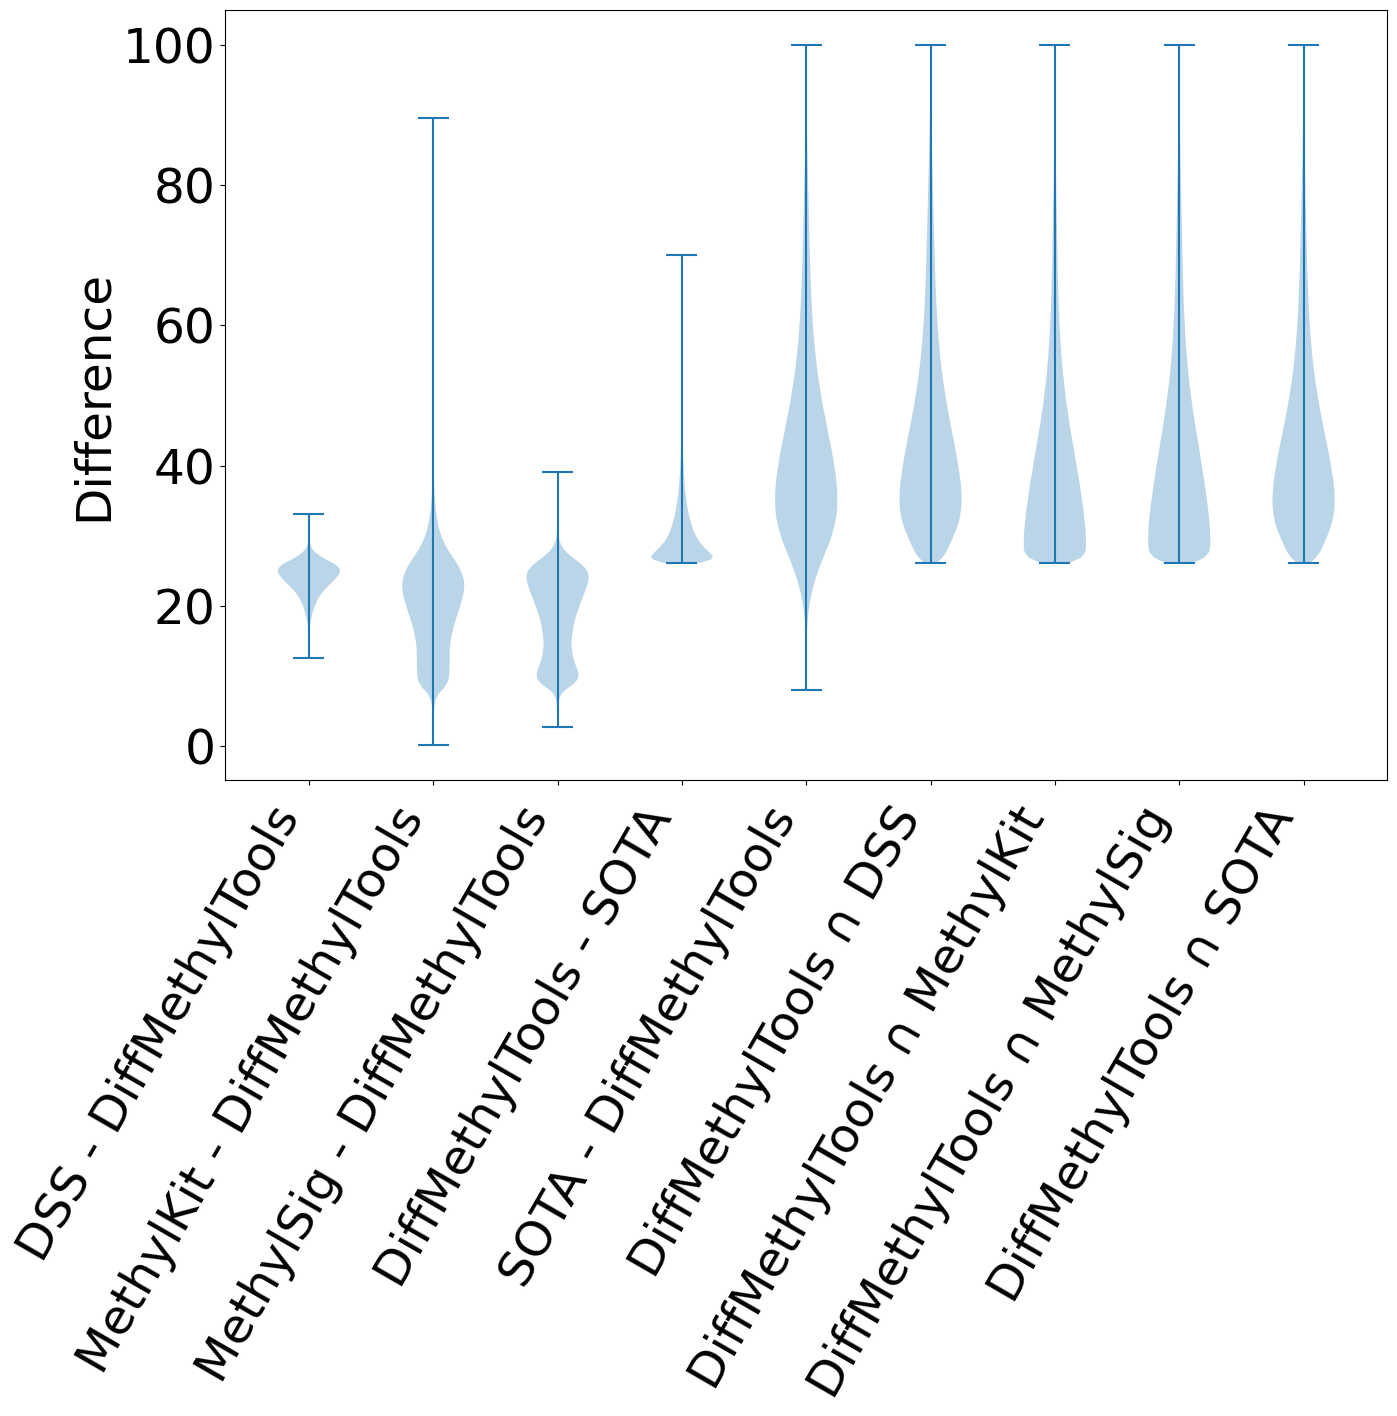

In [411]:
import matplotlib as mpl

mpl.rcParams['font.size'] = 35

data_with_labels = [
    (dss_only_diff, "DSS - DiffMethylTools"),
    (methyl_only_diff, "MethylKit - DiffMethylTools"),
    (methylsig_only_diff, "MethylSig - DiffMethylTools"),
    (our_only_diff, "DiffMethylTools - SOTA"),
    (all_sota_diff, "SOTA - DiffMethylTools"),
    (our_dss_diff, "DiffMethylTools ∩ DSS"),
    (our_methylkit_diff, "DiffMethylTools ∩ MethylKit"),
    (our_methylsig_diff, "DiffMethylTools ∩ MethylSig"),
    (our_all_diff, "DiffMethylTools ∩ SOTA")
]
#  ∩
filtered_data_with_labels = [(data, label) for data, label in data_with_labels if len(data) > 0]

filtered_data, labels = zip(*filtered_data_with_labels) if filtered_data_with_labels else ([], [])


plt.figure(figsize=(15, 10))

if filtered_data:
    plt.violinplot(filtered_data)
    plt.xticks(range(1, len(labels) + 1), labels)
    plt.ylabel("Difference")
    plt.xticks(rotation=60, ha="right")
    plt.tick_params(axis='x', pad=10)
    plt.show()
else:
    print("No valid data to plot.")